In [219]:
from __future__ import division
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from SpikeSep import SAD, prefix_filenames, break_small
from scipy.io import wavfile
from librosa import stft

In [245]:
pos = [1, 8]
sample = "A"
break_w_ms = 200  # 200ms

# SOSAD

In [257]:
th = 0.9
sad = SAD(pos, sample, frame_len=2048, frame_step=512, break_w_ms=break_w_ms, jit=12)
so_sad_result = sad.get_SOSAD(frame_len=8192, frame_step=2048, th=th, use_cache=True)

Using cached...SOSAD


# GCCSAD

In [252]:
th = 0.6
lp = 10
sides = [0, -1]

sad = SAD(pos, sample, frame_len=2048, frame_step=512, break_w_ms=break_w_ms)
gcc_sad_result = sad.get_GCCSAD(frame_len=1024, frame_step=128, th=th, lp=lp, sides=sides, use_cache=True)

# MNICASAD

In [253]:
th = 0.5
sad = SAD(pos, sample, frame_len=2048, frame_step=120, break_w_ms=break_w_ms)
mnica_sad_result = sad.get_MNICASAD(cut_f=20, th=th, res_f=200, use_cache=True)

Iteration 28: 0.9753 || 0.8638 

# Plotting

In [254]:
def norm_envs(e1, e2, m1, m2):
    if len(m1) > len(e1):
        R = int(np.floor(len(m1) / len(e1)))
        e1 = np.repeat(e1, R)
        e2 = np.repeat(e2, R)
    else:
        R = int(np.floor(len(e1) / len(m1)))
        e1 = e1[::R]
        e2 = e2[::R]
    min_len = min([len(e1), len(m1)])
    e1 = e1[:min_len]
    e2 = e2[:min_len]
    m1 = m1[:min_len]
    m2 = m2[:min_len]

    if np.corrcoef(e1, m1)[0, 1] < 0:
        _e1 = e1[:]
        e1 = e2[:]
        e2 = _e1[:]



    e1 = e1[:min([len(m1), len(e1)])].astype('float32')

    e2 = e2[:min([len(m2), len(e2)])].astype('float32')

    # e1 -= np.mean(e1)
    e1 -= np.min(e1)
    e1 /= np.max(np.abs(e1))

    # e2 -= np.mean(e2)
    e2 -= np.min(e2)
    e2 /= np.max(np.abs(e2))

    # m1 -= np.mean(m1)
    m1 -= np.min(m1)
    m1 /= np.max(np.abs(m1))

    # m2 -= np.mean(m2)
    m2 -= np.min(m2)
    m2 /= np.max(np.abs(m2))
    return e1, e2, m1, m2

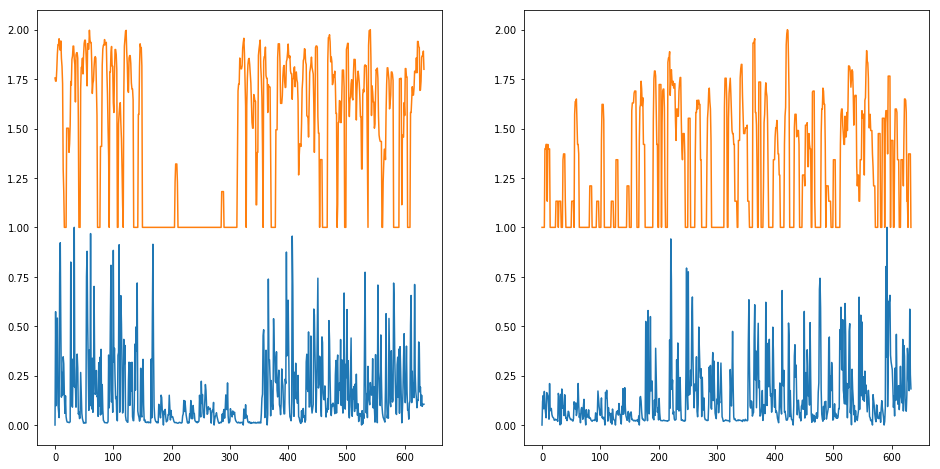

In [249]:
data = so_sad_result
m1 = data['env1']
m2 = data['env2']

e1_m = mnica_sad_result['first']
e2_m = mnica_sad_result['second']

e1_g = gcc_sad_result['first']
e2_g = gcc_sad_result['second']

e1_so = so_sad_result['first']
e2_so = so_sad_result['second']

if len(m1) > len(e1):
    R = int(np.floor(len(m1) / len(e1)))
    e1 = np.repeat(e1, R)
    e2 = np.repeat(e2, R)
else:
    R = int(np.floor(len(e1) / len(m1)))
    e1 = e1[::R]
    e2 = e2[::R]
min_len = min([len(e1), len(m1)])
e1 = e1[:min_len]
e2 = e2[:min_len]
m1 = m1[:min_len]
m2 = m2[:min_len]

if np.corrcoef(e1, m1)[0, 1] < 0:
    _e1 = e1[:]
    e1 = e2[:]
    e2 = _e1[:]



e1 = e1[:min([len(m1), len(e1)])].astype('float32')

e2 = e2[:min([len(m2), len(e2)])].astype('float32')

# e1 -= np.mean(e1)
e1 -= np.min(e1)
e1 /= np.max(np.abs(e1))

# e2 -= np.mean(e2)
e2 -= np.min(e2)
e2 /= np.max(np.abs(e2))

# m1 -= np.mean(m1)
m1 -= np.min(m1)
m1 /= np.max(np.abs(m1))

# m2 -= np.mean(m2)
m2 -= np.min(m2)
m2 /= np.max(np.abs(m2))
beg = 0
end = -1
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,2,1)
ax.plot(e1[beg:end])
ax.plot(m1[beg:end] + 1)
ax = fig.add_subplot(1,2,2)
ax.plot(e2[beg:end])
ax.plot(m2[beg:end] + 1)

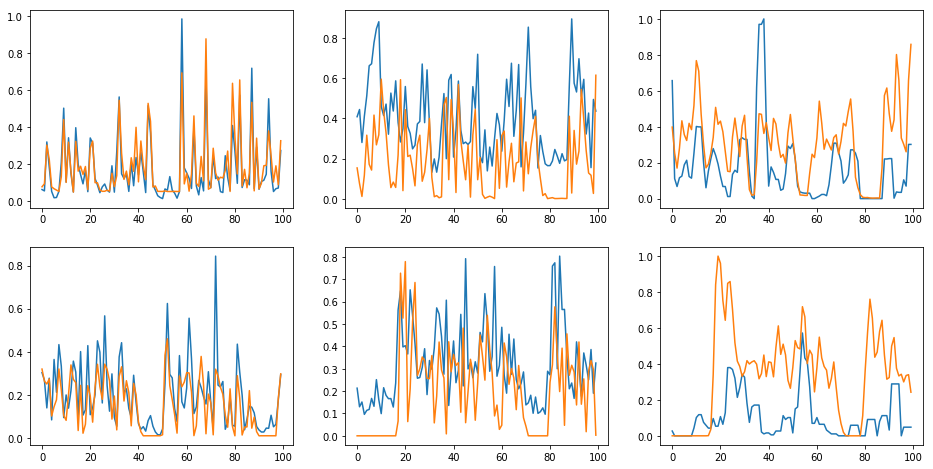

In [255]:
e1_m = mnica_sad_result['first']
e2_m = mnica_sad_result['second']
m1_m = mnica_sad_result['env1']
m2_m = mnica_sad_result['env2']

e1_g = gcc_sad_result['first']
e2_g = gcc_sad_result['second']
m1_g = gcc_sad_result['env1']
m2_g = gcc_sad_result['env2']

e1_s = so_sad_result['first']
e2_s = so_sad_result['second']
m1_s = so_sad_result['env1']
m2_s = so_sad_result['env2']

e1_m, e2_m, m1_m, m2_m = norm_envs(e1_m, e2_m, m1_m, m2_m)
e1_g, e2_g, m1_g, m2_g = norm_envs(e1_g, e2_g, m1_g, m2_g)
e1_s, e2_s, m1_s, m2_s = norm_envs(e1_s, e2_s, m1_s, m2_s)

R_m = int(np.ceil(len(e1_m) / len(e1_s)))
e1_m, e2_m, m1_m, m2_m = e1_m[::R_m], e2_m[::R_m], m1_m[::R_m], m2_m[::R_m]
R_g = int(np.ceil(len(e1_g) / len(e1_s)))
e1_g, e2_g, m1_g, m2_g = e1_g[::R_g], e2_g[::R_g], m1_g[::R_g], m2_g[::R_g]
min_len = min([len(e1_m), len(e1_s), len(e1_g)])
e1_m, e2_m, m1_m, m2_m = e1_m[:min_len], e2_m[:min_len], m1_m[:min_len], m2_m[:min_len]
e1_g, e2_g, m1_g, m2_g = e1_g[:min_len], e2_g[:min_len], m1_g[:min_len], m2_g[:min_len]
JIT = 3
e1_s, e2_s, m1_s, m2_s = e1_s[JIT:min_len + JIT], e2_s[JIT:min_len + JIT], m1_s[:min_len], m2_s[:min_len]

beg = 500
end = 600

fig = plt.figure(figsize=(16,8))

for e, m, i in zip([e2_m, e1_g, e1_s, e1_m, e2_g, e2_s], [m1_m, m1_g, m1_s, m2_m, m2_g, m2_s], range(6)):
    ax = fig.add_subplot(2,3,i+1)
    ax.plot(e[beg:end])
    ax.plot(m[beg:end])

# VAD

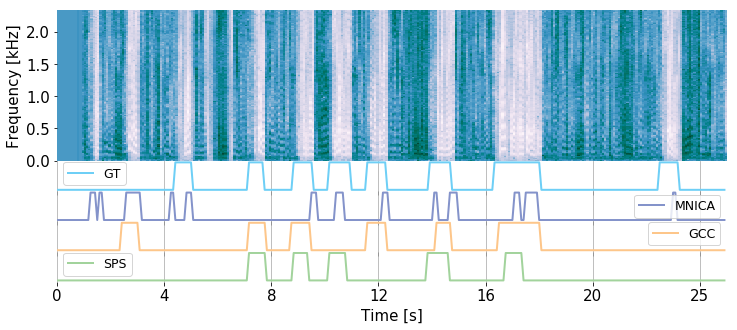

In [471]:
from matplotlib import gridspec

plot_color = ['#F7977A','#FDC68A','#A2D39C','#6ECFF6','#8493CA','#BC8DBF','#F6989D','#FFF79A']

sad1_m = mnica_sad_result['sad1']
sad2_m = mnica_sad_result['sad2']
gt1_m = np.log(mnica_sad_result['env1'] + 1)
gt2_m = np.log(mnica_sad_result['env2'] + 1)

sad1_g = gcc_sad_result['sad1']
sad2_g = gcc_sad_result['sad2']
gt1_g = np.log(gcc_sad_result['env1'] + 1)
gt2_g = np.log(gcc_sad_result['env2'] + 1)

sad1_s = so_sad_result['sad1']
sad2_s = so_sad_result['sad2']
gt1_s = np.log(so_sad_result['env1'] + 1)
gt2_s = np.log(so_sad_result['env2'] + 1)

sad1_m, sad2_m, gt1_m, gt2_m = norm_envs(sad1_m, sad2_m, gt1_m, gt2_m)
sad1_g, sad2_g, gt1_g, gt2_g = norm_envs(sad1_g, sad2_g, gt1_g, gt2_g)
sad1_s, sad2_s, gt1_s, gt2_s = norm_envs(sad1_s, sad2_s, gt1_s, gt2_s)

# PLOT
show_n_steps = 300
show_n_freq = 200
freq_step = 500 # Hertz
time_step = 4 # seconds


win_length = 2048
hop_length = 128

t = np.arange(0, show_n_steps, time_step * np.ceil(fs / 2048).astype('int32'))
t_l = ["%.0f" % i for i in t * 2048 / fs]

f = np.arange(0, show_n_freq, (win_length / 2 + 1)  / (fs / 2 / freq_step))
f_l = ["%.1f" % i for i in f / 1000 * (fs / 2 / (win_length / 2 + 1))]
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)
plt.figure(figsize=(12,5))
# fig, axs = plt.subplots(5, 1, sharex=True, figsize=(15,15))
plt.subplots_adjust(hspace=0)
# plt.subplots_adjust(sharex=True)
gs  = gridspec.GridSpec(5, 1, height_ratios=[5, 1 ,1, 1,1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])

ax2.plot(break_small(sad1_m, 30)[::17][300:600], color=plot_color[4], linewidth=2)
ax2.set_xlim([0,300])
# ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_frame_on(False)
ax2.xaxis.grid(True)
ax2.set_xticks(t) 
ax2.set_xticklabels([])
ax2.legend(['MNICA'], fontsize='small')



R_m = int(np.ceil(len(sad1_m) / len(sad1_s)))
sad1_m, sad2_m, gt1_m, gt2_m = sad1_m[::R_m], sad2_m[::R_m], gt1_m[::R_m], gt2_m[::R_m]
R_g = int(np.ceil(len(sad1_g) / len(sad1_s)))
sad1_g, sad2_g, gt1_g, gt2_g = sad1_g[::R_g], sad2_g[::R_g], gt1_g[::R_g], gt2_g[::R_g]
min_len = min([len(sad1_m), len(sad1_s), len(sad1_g)])
sad1_m, sad2_m, gt1_m, gt2_m = sad1_m[:min_len], sad2_m[:min_len], gt1_m[:min_len], gt2_m[:min_len]
sad1_g, sad2_g, gt1_g, gt2_g = sad1_g[:min_len], sad2_g[:min_len], gt1_g[:min_len], gt2_g[:min_len]
JIT = 3
sad1_s, sad2_s, gt1_s, gt2_s = sad1_s[JIT:min_len + JIT], sad2_s[JIT:min_len + JIT], gt1_s[:min_len], gt2_s[:min_len]

GT = np.float32(0.95 * gt1_s > gt2_s)

beg = 300
end = -1

# spec
m2 = stft(sad.gt8, sad.frame_len, sad.frame_step, window=np.hanning).T
m1 = stft(sad.gt1, sad.frame_len, sad.frame_step, window=np.hanning).T

pos1 = np.abs(m1)[::4][beg:beg+300, :]
neg1 = np.abs(m2)[::4][beg:beg+300, :]



im = ax0.imshow((-np.log(pos1[:, :show_n_freq] + 1) + np.log(neg1[:, :show_n_freq] + 1)).T , aspect="auto",cmap = 'PuBuGn')
ax0.invert_yaxis()
ax0.get_xaxis().set_visible(False)
ax0.set_frame_on(False)
ax0.set_yticks(f) 
ax0.set_yticklabels(f_l)
ax0.set_ylabel('Frequency [kHz]')

# cbaxes = fig.add_axes([0.8, 0.1, 0.03, 0.8]) 
# cb = plt.colorbar(ax0, cax = cbaxes)  
# plt.colorbar(im, ax=ax0)


# ax.set_xlim([0,600])

# axs[5].plot(break_small(sad1_m[beg:beg+600], 4))
# axs[5].set_xlim([0,len(GT)])
ax3.plot(break_small(sad1_g[beg:end], 7) + 2, color=plot_color[1], linewidth=2)
ax3.set_xlim([0,300])
# ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax3.set_frame_on(False)
ax3.xaxis.grid(True)
ax3.set_xticks(t) 
ax3.set_xticklabels([])
ax3.legend(['GCC'], fontsize='small')

ax4.plot(break_small(sad1_s[beg:end], 7) + 4, color=plot_color[2], linewidth=2)
ax4.set_xlim([0,300])
ax4.get_yaxis().set_visible(False)
ax4.set_frame_on(False)

ax4.set_xticks(t) 
ax4.set_xticklabels(t_l)
ax4.set_xlabel('Time [s]')
ax4.xaxis.grid(True)
ax4.legend(['SPS'], fontsize='small')


ax1.plot(break_small(GT[beg:end], 7) + 6, color=plot_color[3], linewidth=2)
ax1.set_xlim([0,300])
# ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.set_frame_on(False)
ax1.xaxis.grid(True)
ax1.set_xticks(t) 
ax1.set_xticklabels([])
ax1.legend(['GT'], fontsize='small')


plt.savefig("sads.pdf", bbox_inches='tight')

# Tables

In [ ]:
class res_obj(object):
    def __init__(self):
        self.SIR_m = 0.0
        self.SIR_s = 0.0
        self.SIR_gt_m = 0.0
        self.SIR_gt_s = 0.0
        self.SIR_best_m = 0.0
        self.SIR_best_s = 0.0
        
        self.SIR_m = 0.0
        self.SIR_s = 0.0
        self.SIR_gt_m = 0.0
        self.SIR_gt_s = 0.0

In [242]:
import pandas as pd
from tabulate import tabulate

OPS_best_m = 0.0
APS_best_m = 0.0
TPS_best_m = 0.0
IPS_best_m = 0.0


for mode in ['SO', 'GCC', 'MNICA', 'BESTMIC']:
# for mode in ['MNICA']:
    df = pd.read_csv('test__final__{}.csv'.format(mode))

    _sir = list(df['SIR1']) + list(df['SIR2'])
    SIR_m, SIR_s = np.mean(_sir), np.std(_sir)
    _sir_gt = list(df['GTSIR1']) + list(df['GTSIR2'])
    SIR_gt_m, SIR_gt_s = np.mean(_sir_gt), np.std(_sir_gt)
    _sir_best = list(df['BESTSIR1']) + list(df['BESTSIR2'])
    SIR_best_m, SIR_best_s = np.mean(_sir_best), np.std(_sir_best)

    _sdr = list(df['SDR1']) + list(df['SDR2'])
    SDR_m, SDR_s = np.mean(_sdr), np.std(_sdr)
    _sdr_gt = list(df['GTSDR1']) + list(df['GTSDR2'])
    SDR_gt_m, SDR_gt_s = np.mean(_sdr_gt), np.std(_sdr_gt)
    _sdr_best = list(df['BESTSDR1']) + list(df['BESTSDR2'])
    SDR_best_m, SDR_best_s = np.mean(_sdr_best), np.std(_sdr_best)

    _sar = list(df['SAR1']) + list(df['SAR2'])
    SAR_m, SAR_s = np.mean(_sar), np.std(_sar)
    _sar_gt = list(df['GTSAR1']) + list(df['GTSAR2'])
    SAR_gt_m, SAR_gt_s = np.mean(_sar_gt), np.std(_sar_gt)
    _sar_best = list(df['BESTSAR1']) + list(df['BESTSAR2'])
    SAR_best_m, SAR_best_s = np.mean(_sar_best), np.std(_sar_best)

    df = pd.read_csv('eval_stoi_{}sad.csv'.format(mode))

    _stoi = list(df['stoi1']) + list(df['stoi2'])
    STOI_m, STOI_s = np.mean(_stoi), np.std(_stoi)
    _stoi_gt = list(df['gtstoi1']) + list(df['gtstoi2'])
    STOI_gt_m, STOI_gt_s = np.mean(_stoi_gt), np.std(_stoi_gt)
    STOI_best_m = df['gtstoi2'][0]
    
    ## PEASS
    df = pd.read_csv('eval_PEASS_{}sad.csv'.format(mode))
    _ops = list(df['OPS1']) + list(df['OPS2'])
    OPS_m, OPS_s = np.mean(_ops), np.std(_ops)
    _ops_gt = list(df['gtOPS1']) + list(df['gtOPS2'])
    OPS_gt_m, OPS_gt_s = np.mean(_ops_gt), np.std(_ops_gt)
    
    _aps = list(df['APS1']) + list(df['APS2'])
    APS_m, APS_s = np.mean(_aps), np.std(_aps)
    _aps_gt = list(df['gtAPS1']) + list(df['gtAPS2'])
    APS_gt_m, APS_gt_s = np.mean(_aps_gt), np.std(_aps_gt)
    
    _tps = list(df['TPS1']) + list(df['TPS2'])
    TPS_m, TPS_s = np.mean(_tps), np.std(_tps)
    _tps_gt = list(df['gtTPS1']) + list(df['gtTPS2'])
    TPS_gt_m, TPS_gt_s = np.mean(_tps_gt), np.std(_tps_gt)
    
    _ips = list(df['IPS1']) + list(df['IPS2'])
    IPS_m, IPS_s = np.mean(_ips), np.std(_ips)
    _ips_gt = list(df['gtIPS1']) + list(df['gtIPS2'])
    IPS_gt_m, IPS_gt_s = np.mean(_ips_gt), np.std(_ips_gt)
    
    ## best PEASS
    if mode == 'SO':
        OPS_best_m = 33.21762

        APS_best_m = 33.006089

        TPS_best_m = 67.176187

        IPS_best_m = 87.111465
    
    
    

    headers = ["{}".format(mode), "EVAL", "W/ GT", "BEST"]
    table = [["SIR", "{:.2f} +/- {:.2f}".format(SIR_m, SIR_s), "{:.2f} +/- {:.2f}".format(SIR_gt_m, SIR_gt_s), SIR_best_m],
             ["SAR", "{:.2f} +/- {:.2f}".format(SAR_m, SAR_s), "{:.2f} +/- {:.2f}".format(SAR_gt_m, SDR_gt_s), SAR_best_m],
             ["SDR", "{:.2f} +/- {:.2f}".format(SDR_m, SDR_s), "{:.2f} +/- {:.2f}".format(SDR_gt_m, SAR_gt_s), SDR_best_m],
             ["STOI", "{:.2f} +/- {:.2f}".format(STOI_m, STOI_s), "{:.2f} +/- {:.2f}".format(STOI_gt_m, STOI_gt_s), STOI_best_m],
             ["PEASS - OPS", "{:.2f} +/- {:.2f}".format(OPS_m, OPS_s), "{:.2f} +/- {:.2f}".format(OPS_gt_m, OPS_gt_s), OPS_best_m],
             ["PEASS - APS", "{:.2f} +/- {:.2f}".format(APS_m, APS_s), "{:.2f} +/- {:.2f}".format(APS_gt_m, APS_gt_s), APS_best_m],
             ["PEASS - TPS", "{:.2f} +/- {:.2f}".format(TPS_m, TPS_s), "{:.2f} +/- {:.2f}".format(TPS_gt_m, TPS_gt_s), TPS_best_m],
             ["PEASS - IPS", "{:.2f} +/- {:.2f}".format(IPS_gt_m, IPS_gt_s), "{:.2f} +/- {:.2f}".format(IPS_m, IPS_s), IPS_best_m]]

    print tabulate(table, headers, tablefmt="fancy_grid")

# a = np.where(np.logical_and(np.logical_and(df['Conf1'] == 7,df['Conf0'] == 9), df['Type'] == 'A'))[0][0]
# print a

╒═════════════╤═════════════════╤═════════════════╤══════════╕
│ SO          │ EVAL            │ W/ GT           │     BEST │
╞═════════════╪═════════════════╪═════════════════╪══════════╡
│ SIR         │ 20.45 +/- 3.02  │ 23.44 +/- 2.14  │ 27.8946  │
├─────────────┼─────────────────┼─────────────────┼──────────┤
│ SAR         │ -1.61 +/- 1.68  │ -0.79 +/- 1.99  │  1.17168 │
├─────────────┼─────────────────┼─────────────────┼──────────┤
│ SDR         │ -1.70 +/- 1.70  │ -0.83 +/- 1.99  │  1.15367 │
├─────────────┼─────────────────┼─────────────────┼──────────┤
│ STOI        │ 0.83 +/- 0.05   │ 0.86 +/- 0.04   │  0.89966 │
├─────────────┼─────────────────┼─────────────────┼──────────┤
│ PEASS - OPS │ 23.92 +/- 6.24  │ 27.76 +/- 7.49  │ 33.2176  │
├─────────────┼─────────────────┼─────────────────┼──────────┤
│ PEASS - APS │ 16.27 +/- 9.65  │ 23.02 +/- 11.59 │ 33.0061  │
├─────────────┼─────────────────┼─────────────────┼──────────┤
│ PEASS - TPS │ 36.52 +/- 11.73 │ 41.97 +/- 10.87 │ 67.

# Specs

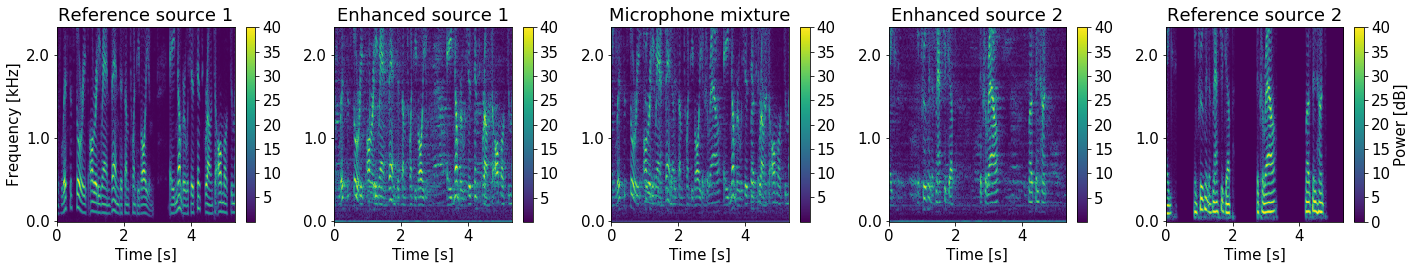

In [466]:
pos = [6,5]
sample = "A"

fs, eval1 = wavfile.read('output_wavs/SOsad_[{}, {}]_{}_1.wav'.format(pos[0], pos[1], sample))
fs, gt1 = wavfile.read('output_wavs/SOsad_[{}, {}]_{}_1_gt.wav'.format(pos[0], pos[1], sample))

fs, eval2 = wavfile.read('output_wavs/SOsad_[{}, {}]_{}_2.wav'.format(pos[0], pos[1], sample))
fs, gt2 = wavfile.read('output_wavs/SOsad_[{}, {}]_{}_2_gt.wav'.format(pos[0], pos[1], sample))

fs, whisper1 = wavfile.read(prefix_filenames + '{}_{}_{}_1.wav'.format(pos[0], pos[1], sample))
trigger_index = np.where(whisper1 > 18000)[0][0]
whisper1 = whisper1[trigger_index + int(fs / 32):].astype('float32')
w1 = whisper1[int(30 * fs):int(40 * fs), 0]
w1 /= np.max(np.abs(w1))

show_n_steps = 1000
show_n_freq = 200
freq_step = 1000 # Hertz
time_step = 2 # seconds

begin = 500

win_length = 2048
hop_length = 128

t = np.array(range(0, show_n_steps, time_step * np.ceil(fs / hop_length).astype('int32')))
t_l = ["%.0f" % i for i in t * hop_length / fs]


f = np.arange(0, show_n_freq, (win_length / 2 + 1)  / (fs / 2 / freq_step))
f_l = ["%.1f" % i for i in f / 1000 * (fs / 2 / (win_length / 2 + 1))]


stft_eval1 = 20 * np.log10(np.abs(stft(eval1, win_length=win_length, hop_length=hop_length)) + 1)
stft_gt1 = 20 * np.log10(np.abs(stft(gt1, win_length=win_length, hop_length=hop_length)) + 1)
stft_w1 = 20 * np.log10(np.abs(stft(w1, win_length=win_length, hop_length=hop_length)) + 1)
stft_eval2 = 20 * np.log10(np.abs(stft(eval2, win_length=win_length, hop_length=hop_length)) + 1)
stft_gt2 = 20 * np.log10(np.abs(stft(gt2, win_length=win_length, hop_length=hop_length)) + 1)

cmap = 'nipy_spectral'
cmap = 'viridis'
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=(20,4))
titles = ['Reference source 1', 'Enhanced source 1', 'Microphone mixture', 'Enhanced source 2', 'Reference source 2']

for i, k in enumerate([stft_gt1, stft_eval1, stft_w1, stft_eval2, stft_gt2]):
    ax = fig.add_subplot(1,5,i + 1)
    im = ax.imshow(np.abs(k[:show_n_freq, begin:begin + show_n_steps]),  aspect='auto', cmap=cmap, vmax=40)
    ax.set_title(titles[i])
    ax.set_xticks(t) 
    ax.set_xticklabels(t_l)
    ax.set_xlabel('Time [s]')
    ax.invert_yaxis()
    ax.set_yticks(f) 
    ax.set_yticklabels(f_l)
    if i == 0:
        ax.set_ylabel('Frequency [kHz]')
    cbar = plt.colorbar(im)
    if i == 4:
        cbar.ax.set_ylabel('Power [dB]')
    
plt.tight_layout()
fig.savefig("foo.pdf", bbox_inches='tight')

41.96178


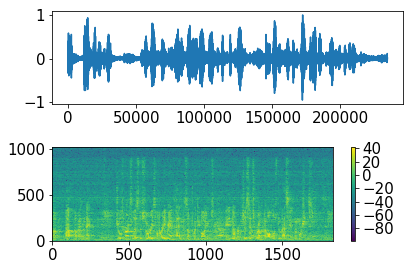

In [463]:
# plt.plot(gt2)
# plt.figure()

a = np.abs(stft(eval1, win_length=win_length, hop_length=hop_length))
g = 20 * np.log10(a + 1e-5)
fig, ax = plt.subplots(2,1)
ax[0].plot(eval1)
im = ax[1].imshow(g, aspect='auto')
ax[1].invert_yaxis()
plt.colorbar(im)
print np.max(g)
plt.tight_layout()